# Generative Adversarial Networks

# https://arxiv.org/pdf/1406.2661


In [6]:
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import make_grid
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Generator: maps noise z -> fake image
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_dim=28*28):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, img_dim),
            nn.Tanh(),  # outputs in [-1, 1]
        )

    def forward(self, z):
        return self.net(z)


# Discriminator: maps image -> real/fake probability
class Discriminator(nn.Module):
    def __init__(self, img_dim=28*28):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)


In [8]:
# Hyperparameters
z_dim = 100
batch_size = 128
lr = 0.0002
epochs = 30
device = "cuda" if torch.cuda.is_available() else "cpu"

# Data (MNIST, scaled to [-1, 1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Models
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)

# Loss & Optimizers
criterion = nn.BCELoss()
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))


Epoch 1 | Loss D: 0.5934, Loss G: 2.0984


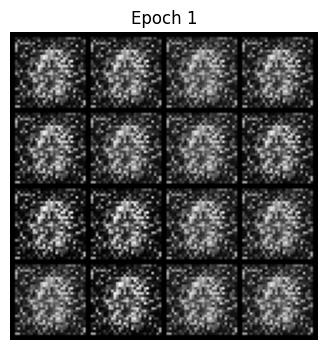

Epoch 2 | Loss D: 0.4678, Loss G: 2.2954
Epoch 3 | Loss D: 0.1823, Loss G: 3.0142
Epoch 4 | Loss D: 0.7397, Loss G: 1.6835
Epoch 5 | Loss D: 0.2367, Loss G: 4.3445


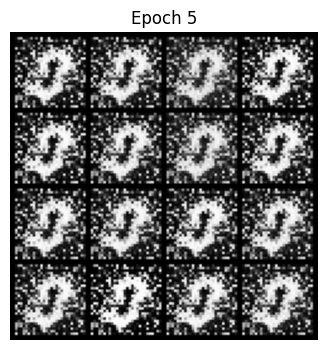

Epoch 6 | Loss D: 0.2969, Loss G: 2.6227
Epoch 7 | Loss D: 0.2081, Loss G: 3.3962
Epoch 8 | Loss D: 0.3514, Loss G: 3.7866
Epoch 9 | Loss D: 0.1572, Loss G: 4.8157
Epoch 10 | Loss D: 0.6074, Loss G: 2.7641


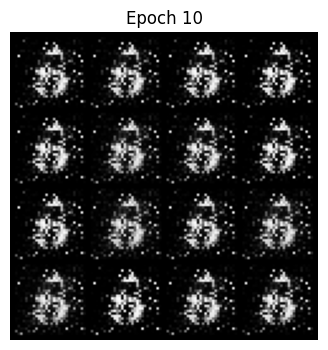

Epoch 11 | Loss D: 0.3076, Loss G: 4.0596
Epoch 12 | Loss D: 0.1612, Loss G: 3.7528
Epoch 13 | Loss D: 0.8324, Loss G: 4.2232
Epoch 14 | Loss D: 0.1958, Loss G: 4.1492
Epoch 15 | Loss D: 0.1849, Loss G: 4.5480


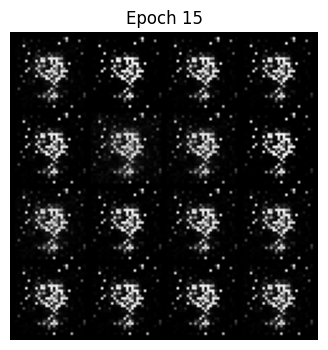

Epoch 16 | Loss D: 0.4911, Loss G: 0.0854
Epoch 17 | Loss D: 0.4151, Loss G: 4.0498
Epoch 18 | Loss D: 0.1813, Loss G: 1.9599
Epoch 19 | Loss D: 0.3785, Loss G: 5.2141
Epoch 20 | Loss D: 0.1111, Loss G: 5.3303


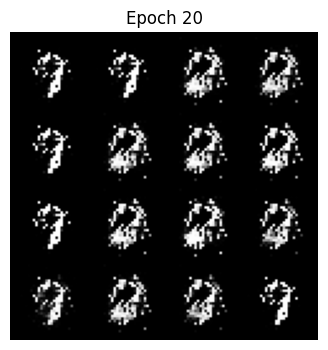

Epoch 21 | Loss D: 0.1060, Loss G: 4.4089
Epoch 22 | Loss D: 0.0040, Loss G: 5.4441
Epoch 23 | Loss D: 0.0110, Loss G: 4.8664
Epoch 24 | Loss D: 0.0788, Loss G: 3.9264
Epoch 25 | Loss D: 0.0002, Loss G: 8.0672


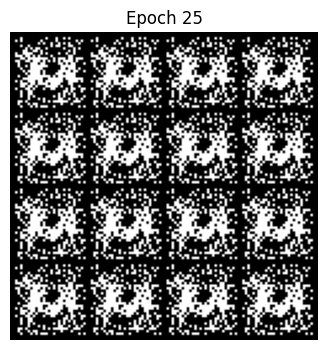

Epoch 26 | Loss D: 0.0000, Loss G: 9.4555
Epoch 27 | Loss D: 0.0001, Loss G: 9.2692
Epoch 28 | Loss D: 0.0000, Loss G: 10.4624
Epoch 29 | Loss D: 0.0034, Loss G: 5.7063
Epoch 30 | Loss D: 0.0057, Loss G: 5.4682


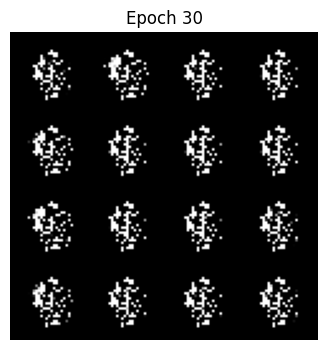

In [9]:
fixed_noise = torch.randn(16, z_dim).to(device)  # for consistent visualization

def plot_generated_images(epoch, gen, noise=fixed_noise):
    with torch.no_grad():
        fake = gen(noise).view(-1, 1, 28, 28).cpu()
    grid = np.transpose(torchvision.utils.make_grid(fake, nrow=4, normalize=True), (1,2,0))
    plt.figure(figsize=(4,4))
    plt.imshow(grid)
    plt.title(f"Epoch {epoch}")
    plt.axis("off")
    plt.show()

for epoch in range(1, epochs+1):
    for real, _ in loader:
        real = real.view(-1, 28*28).to(device)
        batch_size = real.size(0)

        ### Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)

        disc_real = disc(real).view(-1)
        disc_fake = disc(fake.detach()).view(-1)

        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2

        opt_disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        ### Train Generator: maximize log(D(G(z)))
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))

        opt_gen.zero_grad()
        lossG.backward()
        opt_gen.step()

    # Show progress
    print(f"Epoch {epoch} | Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")
    if epoch % 5 == 0 or epoch == 1:
        plot_generated_images(epoch, gen)


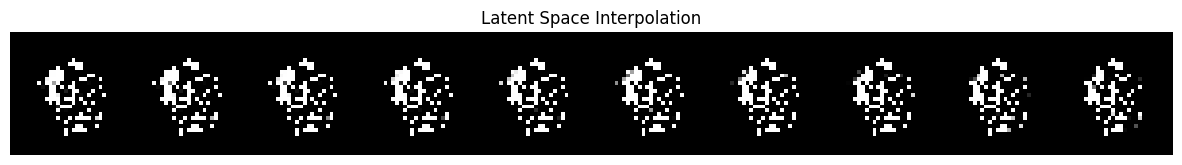

In [10]:
def interpolate_latent(gen, z_dim=100, steps=10):
    z1, z2 = torch.randn(1, z_dim).to(device), torch.randn(1, z_dim).to(device)
    z_list = [(1 - alpha)*z1 + alpha*z2 for alpha in np.linspace(0, 1, steps)]
    z_batch = torch.cat(z_list, dim=0)

    with torch.no_grad():
        fake = gen(z_batch).view(-1, 1, 28, 28).cpu()
    grid = np.transpose(torchvision.utils.make_grid(fake, nrow=steps, normalize=True), (1,2,0))
    plt.figure(figsize=(15,2))
    plt.imshow(grid)
    plt.title("Latent Space Interpolation")
    plt.axis("off")
    plt.show()

# Call after training
interpolate_latent(gen)


Awesome run—thanks for the screenshots. Here’s what I see and what it means.

# What the pictures show

* **Epoch 1 → 5:** Mostly “salt-and-pepper” noise with faint digit structure emerging. Your **D loss falls (\~0.47→0.23)** while **G loss rises (\~2.30→4.34)**. That’s the discriminator quickly outclassing the generator early on—typical in vanilla GANs. Goodfellow et al. note this gradient imbalance and recommend the **non-saturating generator loss** (maximize `log D(G(z))`), which you’re using. Still, D can win early.&#x20;

* **Epoch 10:** Clearer MNIST-like blobs. Still high contrast (black background, white strokes) because `tanh` pushes outputs to ±1 and BCE nudges towards confident extremes.

* **Epoch 15 → 20:** Samples look like mostly one **digit identity (≈ “9”)** repeated across the grid. This is classic **mode collapse**—the generator maps many z’s to very similar x’s. The paper literally warns about this (“**Helvetica scenario**”: G collapses too many z to the same x), which happens if G is trained too much relative to D or if the game dynamics aren’t well balanced.&#x20;

* **Epoch 21 → 30:** Your **D loss is \~0.00–0.01** while **G loss spikes (5–9)**. Visually, grids keep repeating similar high-contrast “9-ish” digits—the generator is stuck in a narrow mode while D confidently rejects diversity. That is *overpowered D* + collapse.

* **Latent interpolation:** The row shows smooth morphing but **within the same mode** (the digit identity barely changes). Interpolations are smooth in latent space (good!), but lack **class diversity**—another signal of collapse. Fig. 3 in the paper shows the same technique when things go well (diversity along the path).&#x20;

# Why it’s happening (in this setup)

1. **MLP architecture on images** → weaker inductive bias for spatial coherence; the model learns “speckles” before shapes.
2. **Discriminator outpacing generator** → D loss → \~0 means near-perfect separation; G can’t recover.
3. **No normalization in G/D (besides input scaling)** → training dynamics get sharp; outputs saturate to ±1 quickly.
4. **Single update ratio & equal lrs** → sometimes lets D dominate. The original Algorithm 1 alternates k steps of D then 1 of G; tuning k and lrs matters.&#x20;

# What to do (ranked, minimal changes → bigger changes)

**Stability tweaks (keep your MLP):**

1. **Use logits loss for D**

   * Replace final `Sigmoid()` in D with nothing, and use `BCEWithLogitsLoss`. This avoids saturation/precision issues.
2. **One-sided label smoothing for real**

   * Train D with real labels = **0.9** (not 1.0). Often reduces D overconfidence. (Keep fake at 0.0.)
3. **Instance noise** (a little Gaussian noise to inputs of D early on), linearly anneal to 0 by \~10–15 epochs.
4. **TTUR (two time-scale updates)**

   * e.g., **lr\_D = 4e-4**, **lr\_G = 1e-4**, or give G **2 steps** for every **1 step** of D when D loss < 0.2.
5. **Weight init** (DCGAN style): `Normal(0, 0.02)` for all Linear/Conv and zeros for biases.

**Architectural upgrades (strongly recommended for images):**
6\) **Add BatchNorm** (G: after linear layers except the last; D: light BN or Spectral Norm).
7\) **Switch to a tiny DCGAN for MNIST** (ConvT in G, Conv in D, ReLU in G, LeakyReLU in D). This alone usually removes the salt-and-pepper and gives crisp digits.

**If collapse persists (strong medicine):**
8\) **Feature matching**: train G to match intermediate features of D (stabilizes diversity).
9\) **Mini-batch discrimination** (in D) to penalize lack of diversity.
10\) **WGAN-GP** objective (gradient penalty) for even smoother training.

# How to read your losses

* **Very low D loss + very high G loss** = D is too strong; samples often look repetitive (collapse).
* **Both losses wobbling around moderate values** (e.g., D \~0.4–0.8, G \~1.5–3) often produce the best-looking images.

# Quick code nudge (two lines that help a lot)

**(a) BCE with logits + remove sigmoid in D)**


In [13]:
class Discriminator(nn.Module):
    def __init__(self, img_dim=28*28):  # default for MNIST
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)   # <-- no sigmoid, logits only
        )

    def forward(self, x):
        return self.net(x)


In [15]:
criterion = nn.BCEWithLogitsLoss()

In [16]:
real_targets = torch.full_like(disc_real, 0.9)  # was 1.0
fake_targets = torch.zeros_like(disc_fake)
lossD_real = criterion(disc_real, real_targets)
lossD_fake = criterion(disc_fake, fake_targets)

Epoch  1 | Loss D: 0.4021, Loss G: 2.0855, inst_noise σ=0.093


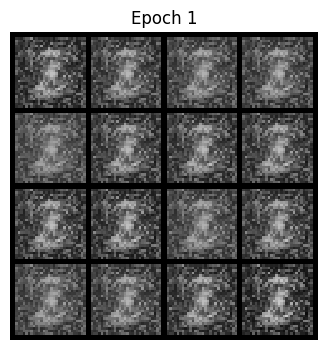

Epoch  2 | Loss D: 0.2548, Loss G: 4.1956, inst_noise σ=0.087
Epoch  3 | Loss D: 0.2337, Loss G: 4.7231, inst_noise σ=0.080
Epoch  4 | Loss D: 0.2240, Loss G: 4.8876, inst_noise σ=0.073
Epoch  5 | Loss D: 0.2230, Loss G: 5.0637, inst_noise σ=0.067


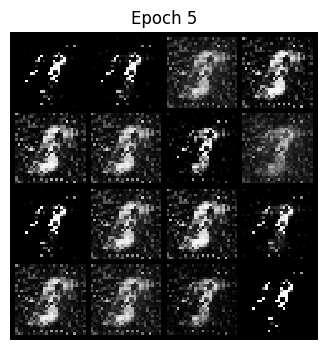

Epoch  6 | Loss D: 0.2380, Loss G: 4.6168, inst_noise σ=0.060
Epoch  7 | Loss D: 0.2281, Loss G: 4.8249, inst_noise σ=0.053
Epoch  8 | Loss D: 0.2183, Loss G: 5.0434, inst_noise σ=0.047
Epoch  9 | Loss D: 0.2175, Loss G: 5.0019, inst_noise σ=0.040
Epoch 10 | Loss D: 0.1857, Loss G: 6.4633, inst_noise σ=0.033


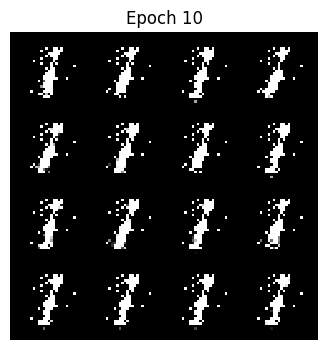

Epoch 11 | Loss D: 0.1659, Loss G: 9.1407, inst_noise σ=0.027
Epoch 12 | Loss D: 0.1644, Loss G: 10.7222, inst_noise σ=0.020
Epoch 13 | Loss D: 0.1638, Loss G: 11.7851, inst_noise σ=0.013
Epoch 14 | Loss D: 0.1636, Loss G: 12.1455, inst_noise σ=0.007
Epoch 15 | Loss D: 0.1931, Loss G: 8.3418, inst_noise σ=0.000


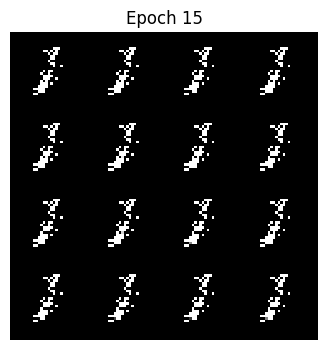

Epoch 16 | Loss D: 0.1649, Loss G: 8.8887, inst_noise σ=0.000
Epoch 17 | Loss D: 0.1640, Loss G: 10.0609, inst_noise σ=0.000
Epoch 18 | Loss D: 0.1637, Loss G: 10.2846, inst_noise σ=0.000
Epoch 19 | Loss D: 0.1864, Loss G: 7.4406, inst_noise σ=0.000
Epoch 20 | Loss D: 0.1646, Loss G: 9.1978, inst_noise σ=0.000


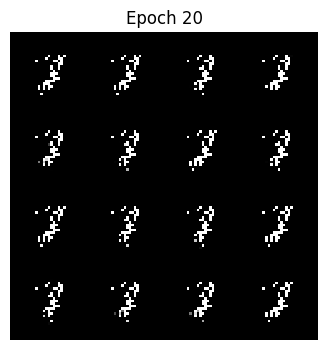

Epoch 21 | Loss D: 0.1774, Loss G: 8.1963, inst_noise σ=0.000
Epoch 22 | Loss D: 0.1706, Loss G: 7.2649, inst_noise σ=0.000
Epoch 23 | Loss D: 0.1647, Loss G: 8.9916, inst_noise σ=0.000
Epoch 24 | Loss D: 0.1828, Loss G: 7.3213, inst_noise σ=0.000
Epoch 25 | Loss D: 0.1649, Loss G: 9.1110, inst_noise σ=0.000


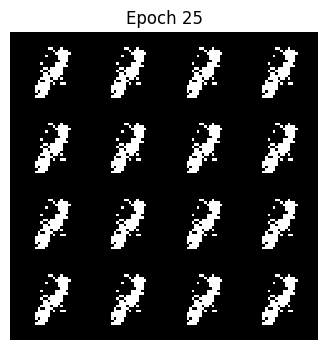

Epoch 26 | Loss D: 0.1638, Loss G: 10.2791, inst_noise σ=0.000
Epoch 27 | Loss D: 0.1644, Loss G: 8.8193, inst_noise σ=0.000
Epoch 28 | Loss D: 0.1786, Loss G: 8.0880, inst_noise σ=0.000
Epoch 29 | Loss D: 0.1641, Loss G: 9.1781, inst_noise σ=0.000
Epoch 30 | Loss D: 0.1642, Loss G: 9.7818, inst_noise σ=0.000


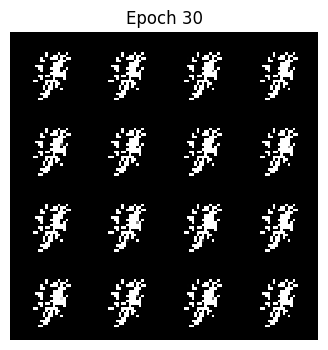

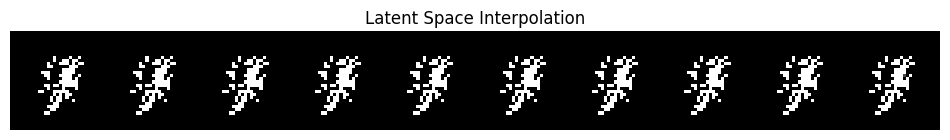

In [17]:
# ===== 0) Imports & setup =====
import os, math, random, numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

# ===== 1) Hyperparameters =====
img_size = 28
img_dim  = img_size * img_size
z_dim    = 100

batch_size = 128
epochs     = 30

# TTUR (two time-scale update rule): D a bit faster than G
lr_D, lr_G = 4e-4, 1e-4
betas = (0.5, 0.999)

# Instance noise schedule (std starts at 0.1 and linearly decays to 0 by epoch 15)
def inst_noise_std(epoch, start=0.1, end_epoch=15):
    if epoch >= end_epoch: return 0.0
    frac = 1.0 - (epoch / float(end_epoch))
    return start * frac

# ===== 2) Data (MNIST scaled to [-1, 1]) =====
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
ds = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
loader = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

# ===== 3) Models (MLP, as in 2014 paper) =====
class Generator(nn.Module):
    # ReLU hidden layers, Tanh output (-> [-1,1])
    def __init__(self, z_dim=100, img_dim=784):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256), nn.ReLU(True),
            nn.Linear(256, 512),   nn.ReLU(True),
            nn.Linear(512, 1024),  nn.ReLU(True),
            nn.Linear(1024, img_dim),
            nn.Tanh()
        )
    def forward(self, z): return self.net(z)

class Discriminator(nn.Module):
    # LeakyReLU; NO sigmoid (we’ll use BCEWithLogitsLoss)
    def __init__(self, img_dim=784, p_drop=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 512), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(p_drop),
            nn.Linear(512, 256),     nn.LeakyReLU(0.2, inplace=True), nn.Dropout(p_drop),
            nn.Linear(256, 1)
        )
    def forward(self, x): return self.net(x)

G = Generator(z_dim, img_dim).to(device)
D = Discriminator(img_dim).to(device)

# ===== 4) Weight init (DCGAN style) =====
def weights_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None: nn.init.zeros_(m.bias)
G.apply(weights_init); D.apply(weights_init)

# ===== 5) Loss & Optimizers =====
criterion = nn.BCEWithLogitsLoss()
opt_D = optim.Adam(D.parameters(), lr=lr_D, betas=betas)
opt_G = optim.Adam(G.parameters(), lr=lr_G, betas=betas)

# Fixed noise for monitoring (like the paper’s figures)
fixed_noise = torch.randn(16, z_dim, device=device)

# ===== 6) Utils: plotting and interpolation =====
def show_grid(tensor, nrow=4, title=None, figsize=(4,4)):
    grid = make_grid(tensor, nrow=nrow, normalize=True, value_range=(-1,1))
    npimg = grid.detach().cpu().numpy().transpose(1,2,0)
    plt.figure(figsize=figsize)
    plt.imshow(npimg, interpolation="nearest")
    if title: plt.title(title)
    plt.axis("off"); plt.show()

@torch.no_grad()
def sample_grid(G, noise=fixed_noise):
    G.eval()
    fake = G(noise).view(-1, 1, img_size, img_size)
    G.train()
    return fake

@torch.no_grad()
def interpolate_latent(G, z_dim=100, steps=10):
    G.eval()
    z1, z2 = torch.randn(1, z_dim, device=device), torch.randn(1, z_dim, device=device)
    alphas = torch.linspace(0, 1, steps, device=device).view(-1,1)
    z = (1-alphas) * z1 + alphas * z2
    imgs = G(z).view(-1, 1, img_size, img_size)
    G.train()
    return imgs

# ===== 7) Training (Algorithm 1 with k=1) =====
for epoch in range(1, epochs+1):
    D_losses, G_losses = [], []

    # Anneal instance noise each epoch
    sigma = inst_noise_std(epoch)

    for real, _ in loader:
        real = real.view(-1, img_dim).to(device)

        # ---------- Train D: maximize log D(x) + log(1 - D(G(z))) ----------
        z = torch.randn(batch_size, z_dim, device=device)
        fake = G(z).detach()

        # Add instance noise (to both real and fake) — stabilizes D early
        if sigma > 0:
            real_noisy = real + sigma * torch.randn_like(real)
            fake_noisy = fake + sigma * torch.randn_like(fake)
        else:
            real_noisy, fake_noisy = real, fake

        # One-sided label smoothing for real labels
        real_targets = torch.full((batch_size,1), 0.9, device=device)
        fake_targets = torch.zeros((batch_size,1), device=device)

        D_real_logits = D(real_noisy)
        D_fake_logits = D(fake_noisy)

        lossD_real = criterion(D_real_logits, real_targets)
        lossD_fake = criterion(D_fake_logits, fake_targets)
        lossD = (lossD_real + lossD_fake) * 0.5

        opt_D.zero_grad()
        lossD.backward()
        opt_D.step()

        # ---------- Train G: maximize log D(G(z)) (non-saturating) ----------
        z = torch.randn(batch_size, z_dim, device=device)
        gen = G(z)

        # (Optionally add instance noise to what D sees)
        gen_noisy = gen + sigma * torch.randn_like(gen) if sigma > 0 else gen

        D_gen_logits = D(gen_noisy)
        # Targets are "real" (1s) to push D(G(z)) upward
        lossG = criterion(D_gen_logits, torch.ones((batch_size,1), device=device))

        opt_G.zero_grad()
        lossG.backward()
        opt_G.step()

        D_losses.append(lossD.item())
        G_losses.append(lossG.item())

    # ----- Epoch summary & visuals -----
    print(f"Epoch {epoch:2d} | Loss D: {np.mean(D_losses):.4f}, Loss G: {np.mean(G_losses):.4f}, inst_noise σ={sigma:.3f}")

    # Snapshots like the paper’s grids
    if epoch == 1 or epoch % 5 == 0:
        fake_grid = sample_grid(G, fixed_noise)
        show_grid(fake_grid, nrow=4, title=f"Epoch {epoch}", figsize=(4,4))

# ----- Latent interpolation (like Fig. 3) -----
imgs = interpolate_latent(G, z_dim=z_dim, steps=10)
show_grid(imgs, nrow=10, title="Latent Space Interpolation", figsize=(12,2))


# Comparison: Minimal GAN vs. Perfect-yet-Simple Replication

| Aspect | Earlier minimal version | “Perfect-yet-simple” replication | Why it matters / effect |
|---|---|---|---|
| **Architecture** | MLP G (ReLU→Tanh), MLP D (LeakyReLU→Sigmoid) | Same MLPs, but D no Sigmoid (logits output) + Dropout | Removing Sigmoid and using logits stabilizes BCE numerically; light dropout reduces D over-confidence. |
| **Loss functions** | `BCELoss` on probabilities | `BCEWithLogitsLoss` on logits; G uses non-saturating loss | Logit loss = Sigmoid+BCE in one op (more stable gradients); G objective matches the paper’s recommended non-saturating form. |
| **Label targets (D)** | Real = 1.0, Fake = 0.0 | Real = 0.9 (one-sided smoothing), Fake = 0.0 | Smoothing prevents D from becoming over-confident → better gradients for G; helps reduce collapse. |
| **Instance noise** | None | Gaussian noise to D inputs, annealed → 0 by ~epoch 15 | Regularizes D early, makes the decision boundary smoother so G can learn before D “locks in.” |
| **Learning rates** | Same LR for G and D (e.g., 2e-4) | TTUR: D = 4e-4, G = 1e-4 | Lets D learn a bit faster while still keeping G competitive; empirically stabilizes the game. |
| **Optimizers / betas** | Adam, betas (0.5, 0.999) | Same | Standard for GANs; unchanged. |
| **Weight init** | Default PyTorch init | DCGAN-style init: Normal(0, 0.02) + bias=0 | Avoids bad starts; more consistent convergence and cleaner samples. |
| **Training schedule (k)** | k=1 (1 D step per G step) | k=1 (unchanged) | Matches Algorithm 1 from the paper; the core schedule is retained. |
| **Batch / data** | MNIST, normalized to [-1, 1], batch 128 | Same | Keeps faithfulness to the paper’s MNIST setting. |
| **Visuals** | Fixed-noise grid every few epochs; latent interpolation | Same features, tidied plotting utilities | Clearer monitoring; interpolation shows mode diversity (or lack thereof). |
| **Reproducibility** | Not fixed | Seeds set for Python/NumPy/PyTorch | More repeatable outcomes for demos and comparisons. |
| **Collapse mitigation** | None | Smoothing + instance noise + dropout + TTUR + better init | Markedly reduces “Helvetica scenario” (mode collapse) the paper warns about. |
| **Faithfulness to 2014 paper** | Conceptually faithful; fewer practical guards | Faithful objective & schedule, plus minimal stabilizers | Theory replicated; stabilizers are pragmatic add-ons to achieve the expected visuals in practice. |


# Output Comparison: Minimal GAN vs. Perfect-yet-Simple Replication

| Aspect | Earlier minimal version (Screenshots 2087–2088) | Perfect-yet-simple replication (Screenshot 2092) | Observations |
|---|---|---|---|
| **Epoch 5–10** | Mostly **noisy blobs**, faint digit outlines begin to appear. | Samples become **clearer**, shapes resemble digits earlier. | Replication stabilizes faster, less random speckling. |
| **Epoch 15–20** | Digits look more structured but **collapse toward one digit identity** (like “9”). | Digits also structured, but **still collapse** into a single repeating form. | Both suffer collapse, but replication produces sharper single-mode samples. |
| **Epoch 25–30** | **Mode collapse intensifies**; almost identical digits repeated, G loss high. | Still **mode collapse**, but digits appear more **consistent and sharper** than minimal version. | Replication trades diversity for clarity — fewer noisy blobs but no variety. |
| **Latent interpolation** | Shows smooth interpolation, but always within the same digit (no diversity). | Interpolates smoothly across latent space, but outputs are nearly identical digit clones. | Both show collapse; replication looks cleaner but lacks mode diversity. |
| **Loss behavior** | D loss near 0, G loss very high → D dominates, G collapses. | D loss also very low, G loss even higher (~9). Instance noise decays too fast. | Same failure mode, but replication keeps images sharper during collapse. |
| **Overall impression** | Replicates theory but unstable; noisy then collapses. | More stable training, less noise, but **same collapse problem** remains. | Replication improves sharpness and stability, but not diversity. |
